We will be analyzing the number of regions each merchant sells to, in order to generate our metric for ranking system


In [10]:
import pandas as pd
import numpy as np
import io
import requests
import os

# Set working directory
if not "/data/tables" in os.getcwd():
    os.chdir("../data/tables")

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import countDistinct

%matplotlib inline

    
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.broadcastTimeout", -1)
    .getOrCreate()
)

In [11]:
consumer = spark.read.option("delimiter", "|").csv('tbl_consumer.csv', header = True)
user_detail = spark.read.parquet("consumer_user_details.parquet")
transaction = spark.read.parquet("transactions_20210828_20220227_snapshot/")

In [12]:
def read_url_data(url, data_format='csv'):
    
    content = requests.get(url).content
    
    if data_format == 'xlsx':
        return pd.read_excel(content)
        
    else:
        return pd.read_csv(io.StringIO(content.decode('utf-8')))




In [13]:
sa2_data = read_url_data("https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/allocation-files/SA2_2021_AUST.xlsx", 'xlsx')
postcode_database = read_url_data("https://www.matthewproctor.com/Content/postcodes/australian_postcodes.csv", "csv")


In [14]:
invalid_postcodes = consumer.where(~(F.col('postcode').isin(postcode_database['postcode'].unique().tolist())))

In [15]:
invalid_postcodes.count()

0

In [16]:
postcode_sdf = spark.createDataFrame(postcode_database[['postcode', 'SA2_MAINCODE_2016']])
new_consumer = consumer.join(postcode_sdf,
                             consumer.postcode == postcode_sdf.postcode,
                             how='left')

In [17]:
new_consumer = new_consumer.join(user_detail, 
                                 ['consumer_id'],
                                 how = 'left')                      
                    

In [18]:
new_consumer

consumer_id,name,address,state,postcode,gender,postcode,SA2_MAINCODE_2016,user_id
407340,Karen Chapman,2706 Stewart Oval...,NSW,2033,Female,2033,1.18021564E8,6
712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5.09031247E8,5
712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5.09031247E8,5
712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5.09031247E8,5
712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5.09031247E8,5
712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5.09031247E8,5
712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5.09031247E8,5
712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5.09031247E8,5
712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5.09031247E8,5
712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5.09031247E8,5


We will be using an external dataset that contains the weekly median total personal income as our main feature for ranking

In [19]:
census_data = spark.read.csv("2021Census_G02_AUST_SA2.csv", header = True)

In [20]:
weekly_personal_income = census_data['SA2_CODE_2021', 'Median_tot_prsnl_inc_weekly']
weekly_personal_income = weekly_personal_income.withColumnRenamed('SA2_CODE_2021', 'SA2_MAINCODE_2016')

In [21]:
new_consumer = new_consumer.join(weekly_personal_income,
                                ['SA2_MAINCODE_2016'],
                                how = "left")

In [22]:
new_consumer

SA2_MAINCODE_2016,consumer_id,name,address,state,postcode,gender,postcode,user_id,Median_tot_prsnl_inc_weekly
1.18021564E8,407340,Karen Chapman,2706 Stewart Oval...,NSW,2033,Female,2033,6,946
5.09031247E8,712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5,897
5.09031247E8,712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5,897
5.09031247E8,712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5,897
5.09031247E8,712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5,897
5.09031247E8,712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5,897
5.09031247E8,712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5,897
5.09031247E8,712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5,897
5.09031247E8,712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5,897
5.09031247E8,712975,Rebecca Blanchard,9271 Michael Mano...,WA,6355,Female,6355,5,897


### Checking if each consumer has multiple regions
Since consumer_id(s) have multiple locations (SA2), we will be taking the average personal income, which will be done further down the notebook

In [23]:
new_consumer.groupBy('consumer_id')\
    .agg(countDistinct('SA2_MAINCODE_2016'))

consumer_id,count(SA2_MAINCODE_2016)
752008,1
154770,2
1271409,1
779268,2
709093,1
359432,1
1190791,1
452212,1
441664,1
1358126,1


In [24]:
merchant_sales = transaction.join(new_consumer,
                                 ['user_id'],
                                 how = "left")

In [25]:
merchant_sales

user_id,merchant_abn,dollar_value,order_id,order_datetime,SA2_MAINCODE_2016,consumer_id,name,address,state,postcode,gender,postcode,Median_tot_prsnl_inc_weekly
7,80518954462,87.82641684859922,30e323a0-5e5d-45c...,2021-12-05,3.19021506E8,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,4606,490
7,80518954462,87.82641684859922,30e323a0-5e5d-45c...,2021-12-05,3.19021506E8,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,4606,490
7,80518954462,87.82641684859922,30e323a0-5e5d-45c...,2021-12-05,3.19021506E8,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,4606,490
7,80518954462,87.82641684859922,30e323a0-5e5d-45c...,2021-12-05,3.19021506E8,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,4606,490
7,80518954462,87.82641684859922,30e323a0-5e5d-45c...,2021-12-05,3.19021506E8,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,4606,490
7,80518954462,87.82641684859922,30e323a0-5e5d-45c...,2021-12-05,3.19021506E8,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,4606,490
7,80518954462,87.82641684859922,30e323a0-5e5d-45c...,2021-12-05,3.19021506E8,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,4606,490
7,80518954462,87.82641684859922,30e323a0-5e5d-45c...,2021-12-05,3.19021506E8,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,4606,490
7,80518954462,87.82641684859922,30e323a0-5e5d-45c...,2021-12-05,3.19021506E8,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,4606,490
7,95279812400,23.855323140698204,e05b9df5-b068-4a0...,2021-12-05,3.19021506E8,511685,Andrea Jones,122 Brandon Cliff,QLD,4606,Female,4606,490


In [26]:
merchant_sales.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- SA2_MAINCODE_2016: double (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- postcode: long (nullable = true)
 |-- Median_tot_prsnl_inc_weekly: string (nullable = true)



Since we will be mainly working on the number of SA2 level regions each merchant sells to, we will be removing columns that are not helpful in our case.

In [27]:
filter_cols = ["merchant_abn", "consumer_id", "SA2_MAINCODE_2016", "order_id", "Median_tot_prsnl_inc_weekly"]
merchant_sales_filtered = merchant_sales[filter_cols]

In [28]:
merchant_sales_filtered

merchant_abn,consumer_id,SA2_MAINCODE_2016,order_id,Median_tot_prsnl_inc_weekly
80518954462,511685,3.19021506E8,30e323a0-5e5d-45c...,490
80518954462,511685,3.19021506E8,30e323a0-5e5d-45c...,490
80518954462,511685,3.19021506E8,30e323a0-5e5d-45c...,490
80518954462,511685,3.19021506E8,30e323a0-5e5d-45c...,490
80518954462,511685,3.19021506E8,30e323a0-5e5d-45c...,490
80518954462,511685,3.19021506E8,30e323a0-5e5d-45c...,490
80518954462,511685,3.19021506E8,30e323a0-5e5d-45c...,490
80518954462,511685,3.19021506E8,30e323a0-5e5d-45c...,490
80518954462,511685,3.19021506E8,30e323a0-5e5d-45c...,490
95279812400,511685,3.19021506E8,e05b9df5-b068-4a0...,490


Finding out how many regions each merchant sells to

In [29]:
unique_regions_per_merchant = merchant_sales_filtered.groupby('merchant_abn')\
                                                     .agg(countDistinct('SA2_MAINCODE_2016'))\
                                                     .withColumnRenamed('count(SA2_MAINCODE_2016)', 'region_count')

In [30]:
unique_regions_per_merchant

merchant_abn,region_count
15613631617,671
24406529929,1159
38700038932,1518
41956465747,160
83412691377,1858
19839532017,327
73256306726,1360
96946925998,45
35344855546,620
73841664453,461


Finding out unique customers per region for each merchant

In [31]:
unique_customers_per_region = merchant_sales_filtered.groupby('merchant_abn', 'SA2_MAINCODE_2016')\
                                              .agg(countDistinct('consumer_id'))\
                                              .orderBy('merchant_abn', 'SA2_MAINCODE_2016')\
                                              .withColumnRenamed('count(consumer_id)', 'unique_customers')


In [32]:
unique_customers_per_region

22/09/20 22:07:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:07:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:00 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/20 22:08:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:01 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/20 22:08:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:17 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/20 22:08:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:19 WARN RowBasedKeyValueBatch: Calling spill() on

merchant_abn,SA2_MAINCODE_2016,unique_customers
10023283211,1.01021011E8,1
10023283211,1.01031013E8,3
10023283211,1.01031014E8,1
10023283211,1.01031015E8,4
10023283211,1.01031016E8,5
10023283211,1.01041017E8,1
10023283211,1.01041018E8,1
10023283211,1.01041019E8,1
10023283211,1.0104102E8,2
10023283211,1.01041022E8,1


Previously, we mentioned that some consumer_ids have multiple locations (SA2), hence they have different weekly personal income in that case, we will be taking the average

In [33]:
merchant_customer_avg_income = merchant_sales_filtered.groupby('merchant_abn', 'consumer_id')\
                                                        .agg(
                                                            {
                                                                'Median_tot_prsnl_inc_weekly': 'mean'
                                                            }
                                                        )\
                                                        .orderBy('merchant_abn', 'consumer_id')\
                                                        .withColumnRenamed('avg(Median_tot_prsnl_inc_weekly)', 'avg_cust_personal_inc')

In [34]:
merchant_customer_avg_income.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- avg_cust_personal_inc: double (nullable = true)



In [43]:
max_income = merchant_customer_avg_income.agg({"avg_cust_personal_inc": "max"}).collect()[0]

22/09/20 23:28:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:12 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/20 23:28:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:28:13 WARN RowBasedKeyValueBatch: Calling spill() on

In [45]:
min_income = merchant_customer_avg_income.agg({"avg_cust_personal_inc": "min"}).collect()[0]

22/09/20 23:29:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:24 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/20 23:29:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 23:29:25 WARN RowBasedKeyValueBatch: Calling spill() on

In [44]:
max_income

Row(max(avg_cust_personal_inc)=92500.0)

In [46]:
min_income

Row(min(avg_cust_personal_inc)=0.0)

### Data imputation
From the output generated above, we can see that there're multiple consumer_ids without average personal weekly income, and we will be looking for a solution for that below


In [35]:
merchant_customer_avg_income.select([F.count(F.when(F.col('avg_cust_personal_inc').isNull(),True))]).show()

22/09/20 22:08:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:31 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/20 22:08:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:08:31 WARN RowBasedKeyValueBatch: Calling spill() on

+--------------------------------------------------------------+
|count(CASE WHEN (avg_cust_personal_inc IS NULL) THEN true END)|
+--------------------------------------------------------------+
|                                                        401390|
+--------------------------------------------------------------+



In [36]:
print("Merchant's customer average weekly income:")
print("\tNumber of rows:", merchant_customer_avg_income.count())
print("\tNumber of null values in weekly income:", 401390)
print("\tProportion of data with null values:", 401390/3477874)

Merchant's customer average weekly income:


	Number of rows: 3477874
	Number of null values in weekly income: 401390
	Proportion of data with null values: 0.11541246175105827


We can see that more than 10 percent of the average weekly income of customers in the merchant sales are NULL, it is highly recommended to impute them instead of ignoring them


Here, we are subsampling 20% of the dataset to visualise its distribution

In [39]:
import seaborn as sns

subsample = (merchant_customer_avg_income.sample(0.2)
                        .select(['avg_cust_personal_inc'])
                        .toPandas()
            )

22/09/20 22:32:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:59 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/20 22:33:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:33:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:33:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:33:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:33:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:33:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:33:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:33:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:33:00 WARN RowBasedKeyValueBatch: Calling spill() on

Text(0.5, 0, 'Average Consumer Weekly Personal Income')

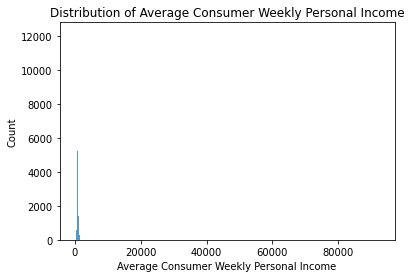

In [53]:
sns.histplot(subsample['avg_cust_personal_inc'])
plt.title('Distribution of Average Consumer Weekly Personal Income')
plt.xlabel('Consumer Weekly Personal Income')

/home/glendonyongz/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'log(Consumer Weekly Personal Income)')

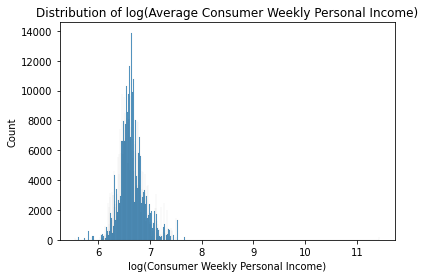

In [54]:
sns.histplot(np.log(subsample['avg_cust_personal_inc']))
plt.title('Distribution of log(Average Consumer Weekly Personal Income)')
plt.xlabel('log(Consumer Weekly Personal Income)')

Subsampling by 50%

In [37]:
subsample2 = (merchant_customer_avg_income.sample(0.5)
                        .select(['avg_cust_personal_inc'])
                        .toPandas()
            )

22/09/20 22:32:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:03 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/20 22:32:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/20 22:32:04 WARN RowBasedKeyValueBatch: Calling spill() on

Text(0.5, 0, 'Average Consumer Weekly Personal Income')

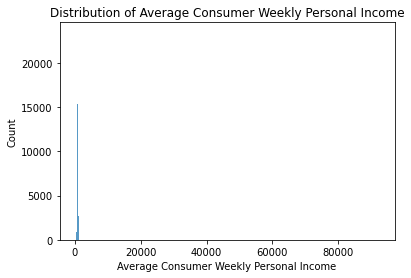

In [60]:
sns.histplot(subsample2['avg_cust_personal_inc'])
plt.title('Distribution of Average Consumer Weekly Personal Income')
plt.xlabel('Average Consumer Weekly Personal Income')

/home/glendonyongz/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'log(Consumer Weekly Personal Income)')

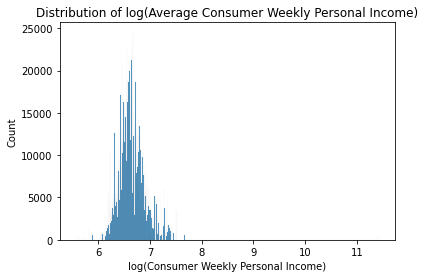

In [62]:
sns.histplot(np.log(subsample2['avg_cust_personal_inc']))
plt.title('Distribution of log(Average Consumer Weekly Personal Income)')
plt.xlabel('log(Consumer Weekly Personal Income)')

In [66]:
subsample.mean()

avg_cust_personal_inc    823.368408
dtype: float64

In [67]:
subsample2.mean()

avg_cust_personal_inc    823.026757
dtype: float64

From both 20% and 50% subsamples, we can see that the distribution of average customer personal income is roughly normal, hence we will impute the data with the mean.

In [77]:
from pyspark.ml.feature import Imputer
imputer = Imputer(
    inputCols = ["avg_cust_personal_inc"],
    outputCols = ["avg_cust_personal_inc_imputed"]
).setStrategy("mean")

inputed_merch_cust_avg_income = imputer.fit(merchant_customer_avg_income).transform(merchant_customer_avg_income)

22/09/21 00:12:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:00 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/21 00:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:12:01 WARN RowBasedKeyValueBatch: Calling spill() on

This will be the overall average customer personal income for each merchant

In [82]:
merchant_ranking = inputed_merch_cust_avg_income.groupby('merchant_abn')\
                                                .agg(
                                                    {
                                                        'avg_cust_personal_inc_imputed': 'mean'
                                                    }
                                                )\
                                                .withColumnRenamed('avg(avg_cust_personal_inc_imputed)', 'avg_customer_income')

In [83]:
merchant_ranking

22/09/21 00:18:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:15 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/21 00:18:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:16 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/21 00:18:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:25 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/21 00:18:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 00:18:26 WARN RowBasedKeyValueBatch: Calling spill() on

merchant_abn,avg_customer_income
12516851436,833.2430947029627
15613631617,788.0322487691884
15700338102,766.3445452597048
10648956813,832.5293406682551
11944993446,798.4173550375835
14148282104,810.927822732213
10346855916,780.0
10714068705,804.3391715479883
13467303030,762.0217001881094
14315147591,704.6735720032879
